<a href="https://colab.research.google.com/github/PetrGavrilin/VKR_URFU/blob/main/VKR_part3_LinearRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Линейная регрессия</h1>

In [4]:
# импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error as mse # метрика MSE от Scikit-learn
from sklearn.metrics import r2_score # коэффициент детерминации  от Scikit-learn
from sklearn.model_selection import cross_validate # кросс-валидация от Scikit-learn

from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, ElasticNet, ElasticNetCV, SGDRegressor
from sklearn import metrics
from math import sqrt

from sklearn.model_selection import RandomizedSearchCV # для поиска при случайном сэмплирование гиперпараметров
from sklearn.model_selection import GridSearchCV

#import scipy.stats as stats # статистические функции библиотеки scipy

import random

In [5]:
import sys
sys.path.append('/content')

from vkr_function import print_scores, plot_predict, my_test_train_split

In [6]:
Y = pd.read_csv('/content/flow_rate.csv')
X_tsfel = np.genfromtxt('/content/X_tsfel.csv', delimiter=',')
X_tsfel_savgol = np.genfromtxt('/content/X_tsfel_savgol.csv', delimiter=',')
borders = pd.read_csv('/content/borders.csv').values.tolist()[0]

In [7]:
Y = np.array(Y['Et'])
X = np.array(X_tsfel)[1:]
#X = X_tsfel

In [8]:
X_train, y_train, X_test, y_test, i_test = my_test_train_split(X, Y, borders)

In [9]:
#LM = ElasticNetCV(max_iter = 10000)
#LM = Ridge()
LM = LinearRegression()
#LM = RidgeCV()
#LM = SGDRegressor()

In [10]:
# Обучение модели и вывод метрик
LM.fit(X_train, y_train)
y_predict = LM.predict(X_test)
print_scores(y_test, y_predict)


Ошибка на тестовых данных
MSE: 0.0012
RMSE: 0.0345
R2 : 0.9977


In [11]:
y_predict_all = LM.predict(X)
print_scores(Y, y_predict_all, False)

Ошибка на полных данных
MSE: 0.0009
RMSE: 0.0295
R2 : 0.9983


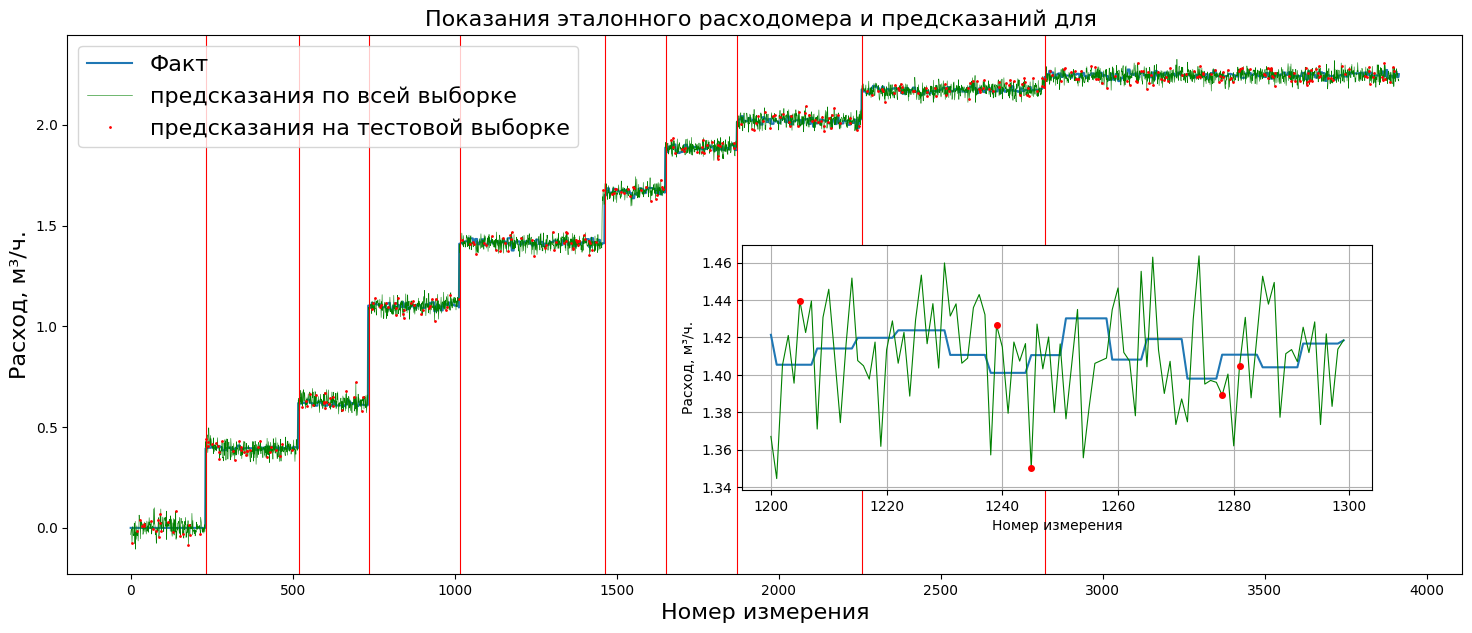

In [12]:
plot_predict(Y, i_test, y_predict, y_predict_all, borders, text="")

Из колебаний графика предсказаний вокруг фактических данных, а также учитывая построенный ранее график из исходных данных по разности времён, можно предположить, что для исключения колебаний показания расхода необходимо применить сглаживание к исходным данным.

Обучение модели на дополнительно обработанных данных с помощью функции Савицкого-Голея

In [13]:
X = np.array(X_tsfel_savgol)[1:]


In [14]:
X_train, y_train, X_test, y_test, i_test = my_test_train_split(X, Y, borders)

In [15]:
# Обучение модели и вывод метрик
LM.fit(X_train, y_train)
y_predict = LM.predict(X_test)
print_scores(y_test, y_predict)

Ошибка на тестовых данных
MSE: 0.0002
RMSE: 0.0153
R2 : 0.9995


In [16]:
y_predict_all = LM.predict(X)
print_scores(Y, y_predict_all, False)

Ошибка на полных данных
MSE: 0.0003
RMSE: 0.0165
R2 : 0.9995


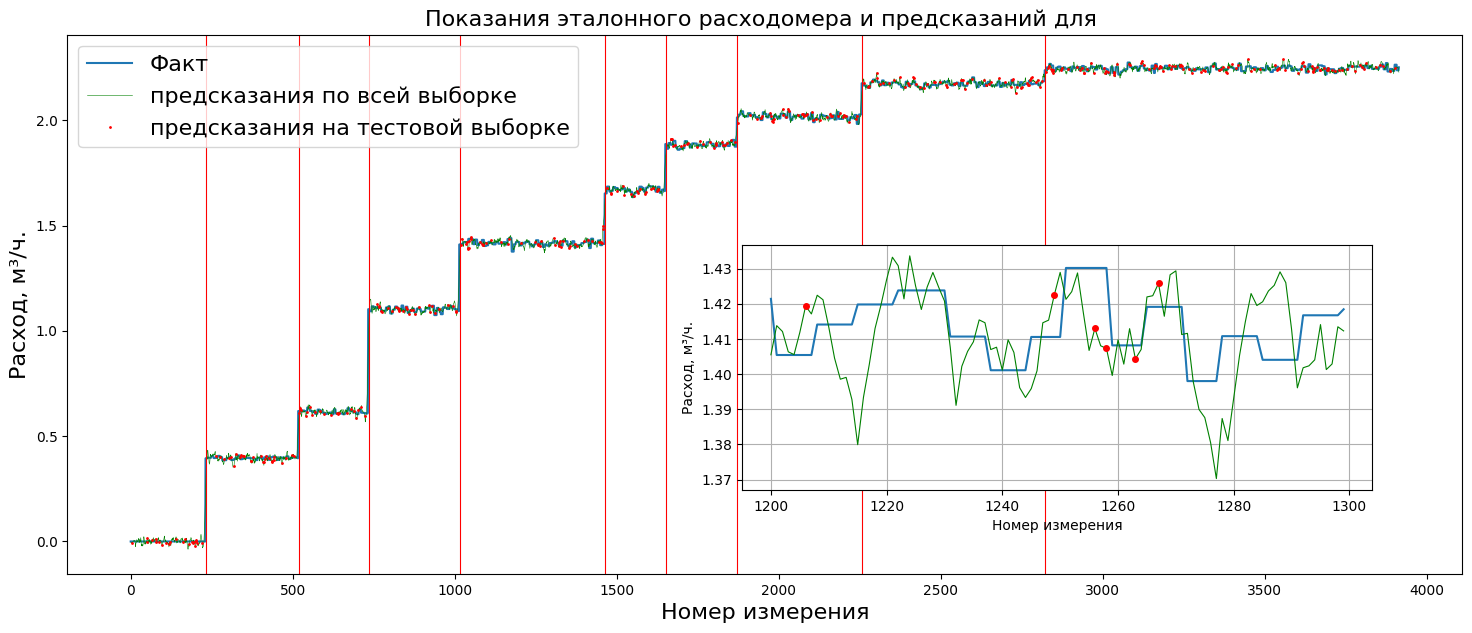

In [17]:
plot_predict(Y, i_test, y_predict, y_predict_all, borders, text="")

Проверим работу модели, приняв за тестовую выборку один из режимов расхода

In [18]:
l_ = len(Y)

i_test = list(range(borders[3],borders[4]))

i_train = list(range(0,l_))
for x1 in i_test:
  i_train.remove(x1)

X_train = X[i_train,:]
y_train = Y[i_train]

X_test = X[i_test,:]
y_test = Y[i_test]

print(len(X_train), len(y_train))

3466 3466


In [19]:
# Обучение модели и вывод метрик
LM.fit(X_train, y_train)
y_predict = LM.predict(X_test)
print_scores(y_test, y_predict)

Ошибка на тестовых данных
MSE: 0.0021
RMSE: 0.0457
R2 : -7.0520


In [20]:
y_predict = LM.predict(X_test)
print_scores(y_test, y_predict)

Ошибка на тестовых данных
MSE: 0.0021
RMSE: 0.0457
R2 : -7.0520


In [21]:
y_predict_all = LM.predict(X)
print_scores(Y, y_predict_all, False)

Ошибка на полных данных
MSE: 0.0004
RMSE: 0.0207
R2 : 0.9992


In [22]:
LM.get_params()

{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}

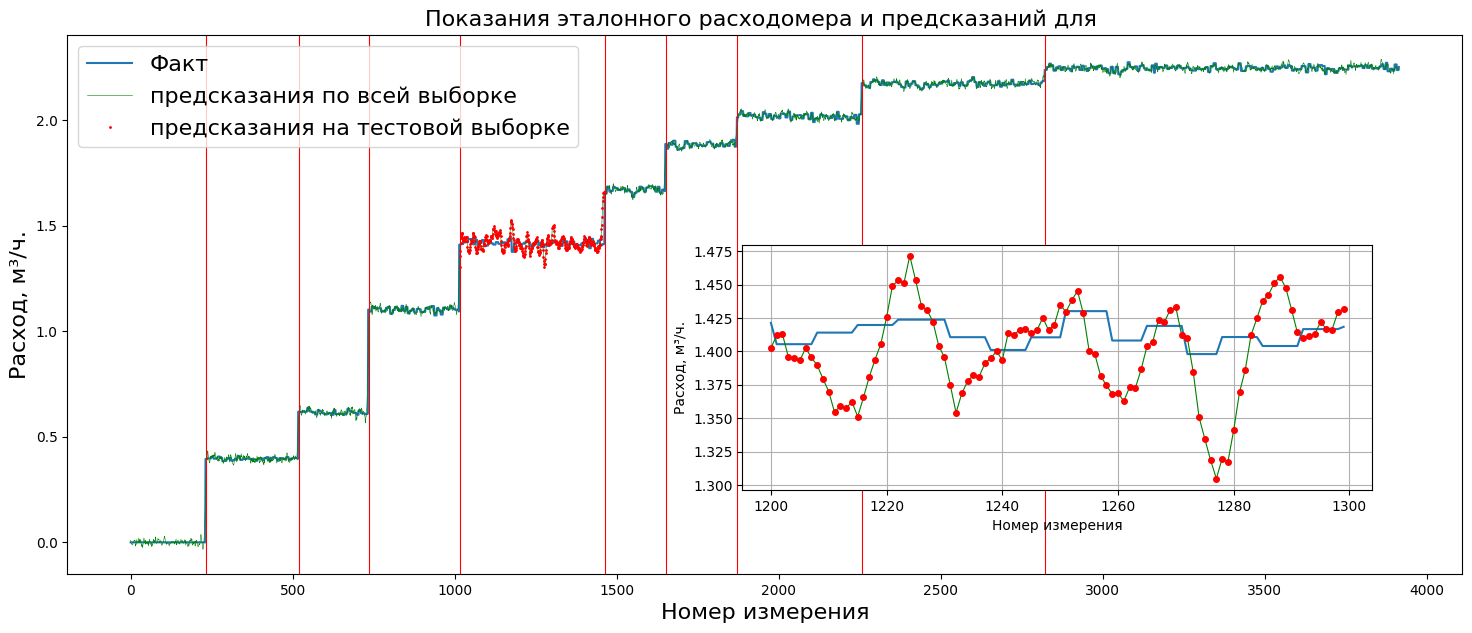

In [23]:
plot_predict(Y, i_test, y_predict, y_predict_all, borders, text="")

In [24]:
Y[1015:1464].sum()/(1464-1015)

1.4169322693003341

In [25]:
y_predict_all[1015:1464].sum()/(1464-1015)

1.4225035503688015